In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2100,00010815_003.png,No Finding,3,10815,065Y,M,PA,2992,2991,0.143000,0.143000
5524,00030106_004.png,Atelectasis|Effusion,4,30106,073Y,M,AP,3056,2544,0.139000,0.139000
102,00000580_001.png,Mass|Pleural_Thickening,1,580,065Y,M,PA,2021,2021,0.194311,0.194311


In [3]:
#Add columns for each finding
label_set = set()

for labels in all_xray_df['Finding Labels'].unique():
    for label in labels.split('|'):
        label_set.add(label)
label_set = sorted(label_set)
#print(label_set)

for label in label_set:
    all_xray_df[label] = np.where(all_xray_df['Finding Labels'].str.contains(label), 1, 0)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
19072,00005067_001.png,No Finding,1,5067,59,F,PA,2522,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14963,00003913_000.png,No Finding,0,3913,34,F,PA,2048,2500,0.171,0.171,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
51218,00012935_015.png,Consolidation|Infiltration|Pneumothorax,15,12935,55,M,PA,2674,2991,0.143,0.143,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
54916,00013750_027.png,No Finding,27,13750,58,M,AP,2500,2048,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5105,00001373_009.png,Cardiomegaly,9,1373,58,M,AP,2500,2048,0.168,0.168,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
65741,00016231_000.png,No Finding,0,16231,42,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43398,00011190_005.png,No Finding,5,11190,22,M,PA,2992,2769,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
66546,00016452_001.png,No Finding,1,16452,53,M,AP,2500,2048,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
65106,00016074_006.png,Effusion,6,16074,43,M,AP,2500,2048,0.168,0.168,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
29321,00007627_004.png,No Finding,4,7627,51,F,PA,2500,2048,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Patient Age


(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

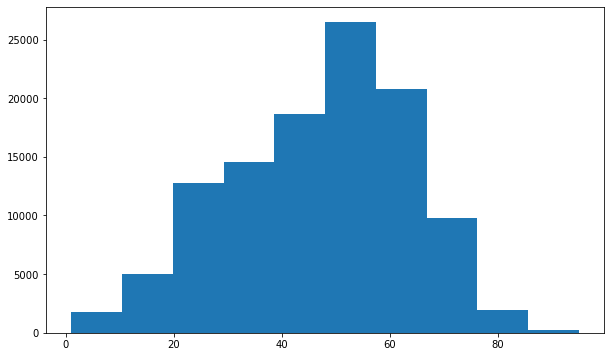

In [4]:
## EDA
# The patient demographic data such as gender, age, patient position,etc. (as it is available)

#show a histogram of the patient ages
print("Patient Age")

#filter out patients with an age > 100 (must be bad data entry)
all_xray_df_age_lt_100 = all_xray_df[all_xray_df['Patient Age'] <= 100]


plt.figure(figsize=(10,6))
plt.hist(all_xray_df_age_lt_100['Patient Age'])


In [5]:
#show data about the patient positions, gender
print("View Position:")

pa_count = len(all_xray_df[all_xray_df['View Position'] == 'PA'])
ap_count = len(all_xray_df[all_xray_df['View Position'] == 'AP'])

print("    {} Xrays are in PA position".format(pa_count))
print("    {} Xrays are in AP position".format(ap_count))

print("\nGender:")

m_count = len(all_xray_df[all_xray_df['Patient Gender'] == 'M'])
f_count = len(all_xray_df[all_xray_df['Patient Gender'] == 'F'])

print("    {} Xrays are male".format(m_count))
print("    {} Xrays are female".format(f_count))

#The number of cases including:
#   number of pneumonia cases,
#   number of non-pneumonia cases
pneumonia_count = len(all_xray_df[all_xray_df['Pneumonia'] == 1])
non_pneumonia_count = len(all_xray_df[all_xray_df['Pneumonia'] != 1])

print("\nPneumonia occurences:")
print("    {} Xrays are Pneumonia".format(pneumonia_count))
print("    {} Xrays are Non-Pneumonia".format(non_pneumonia_count))

View Position:
    67310 Xrays are in PA position
    44810 Xrays are in AP position

Gender:
    63340 Xrays are male
    48780 Xrays are female

Pneumonia occurences:
    1431 Xrays are Pneumonia
    110689 Xrays are Non-Pneumonia


[Text(0, 0.5, 'Occurances Comorbid with Pneumonia')]

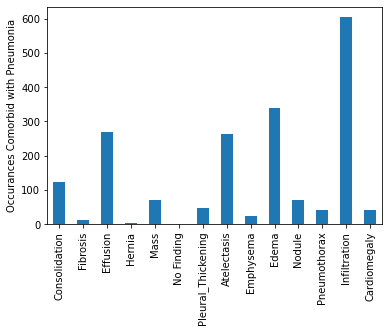

In [6]:
#The distribution of other diseases that are comorbid with pneumonia
label_set_no_pneumonia = set(label_set)
label_set_no_pneumonia.remove('Pneumonia')

pneumonia_xray_df = all_xray_df[all_xray_df['Pneumonia'] == 1]

ax = pneumonia_xray_df[label_set_no_pneumonia].sum().plot(kind='bar')
ax.set(ylabel = 'Occurances Comorbid with Pneumonia')

In [7]:
#Number of disease per patient

all_xray_df[label_set].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Occurances')]

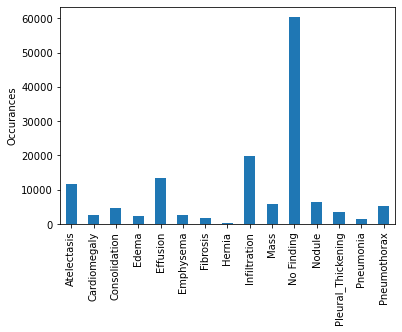

In [8]:
#Show a bar chart of the total disease occurances
ax = all_xray_df[label_set].sum().plot(kind='bar')
ax.set(ylabel = 'Occurances')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


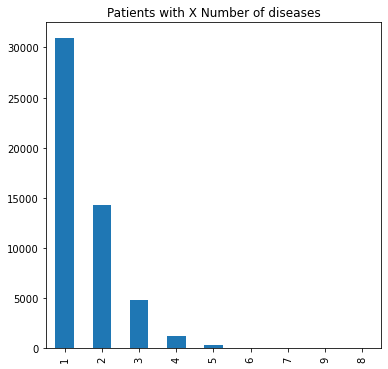

In [9]:
#Number of diseases per patient

#filter out patients with 'No Finding'
all_xray_df_with_disease = all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']


all_xray_df_with_disease['disease_count'] = all_xray_df_with_disease['Finding Labels'].str.count('\|') + 1

plt.figure(figsize=(6,6))
all_xray_df_with_disease['disease_count'].value_counts().plot(kind='bar', title='Patients with X Number of diseases')


In [10]:
#Pixel-level assessments of the imaging data for healthy & disease states of 
#interest (e.g. histograms of intensity values) and compare distributions across diseases.

#add image path for all images
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
10107,00002627_000.png,No Finding,0,2627,51,M,PA,2500,2048,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,/data/images_002/images/00002627_000.png
91617,00022837_048.png,No Finding,48,22837,66,M,PA,2544,3056,0.139,0.139,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,/data/images_010/images/00022837_048.png
4296,00001170_020.png,Atelectasis|Pneumothorax,20,1170,23,M,PA,2500,2048,0.168,0.168,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/data/images_001/images/00001170_020.png
86790,00021409_006.png,Atelectasis|Infiltration,6,21409,25,M,PA,2992,2991,0.143,0.143,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,/data/images_010/images/00021409_006.png
38045,00009996_013.png,No Finding,13,9996,70,M,PA,2992,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,/data/images_005/images/00009996_013.png


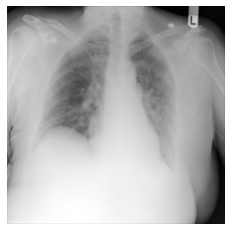

In [11]:
import matplotlib.image as mpimg
from skimage.transform import resize

#show an image to make sure the path column is correct.
img = mpimg.imread(all_xray_df.iloc[101]['path']) 
img_resized = resize(img, (256, 256))

plt.axis('off') 
plt.imshow(img_resized,cmap='gray')

plt.show()

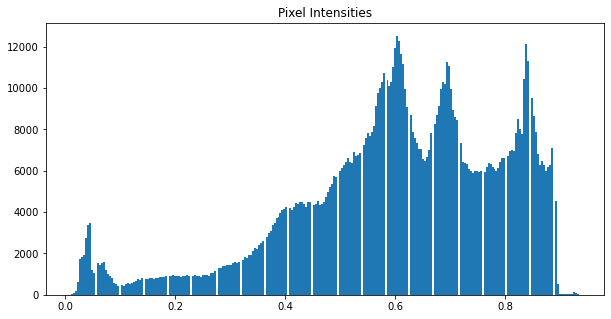

In [12]:
#plot a histogram of the image pixel intensity values
img = mpimg.imread(all_xray_df.iloc[101]['path']) 

plt.figure(figsize=(10,5))
plt.title("Pixel Intensities")
plt.hist(np.asarray(img).ravel(), bins = 256);

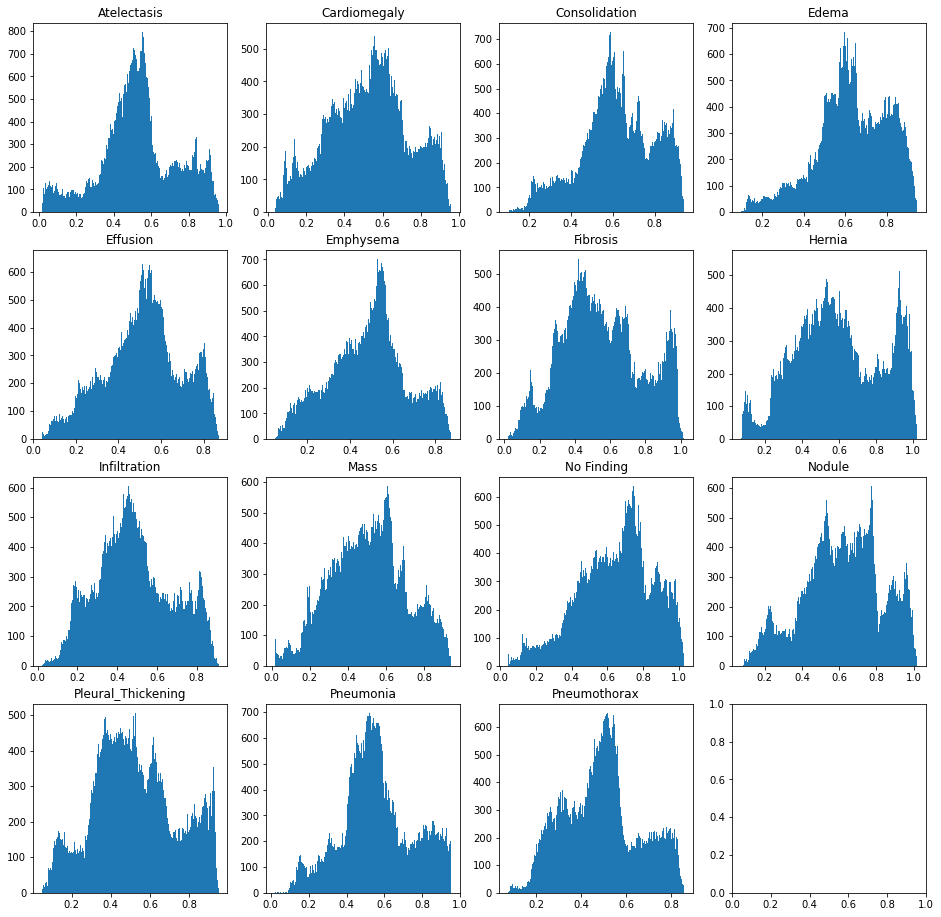

In [13]:
# loop through all diseases and average the pixel intensities for each disease
from skimage import color
from skimage.transform import rescale, resize

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
all_pixel_values_dict = {}
stop_after_x_images = 10

for label in label_set:
    all_pixel_values = np.zeros(256*256)
    label_xray_df = all_xray_df[all_xray_df[label] == 1]

    counter = 0
    for index, row in label_xray_df.iterrows():
        img = mpimg.imread(row['path']) 
        img = color.rgb2gray(img)
        img = resize(img, (256, 256))
        all_pixel_values += np.asarray(img).ravel()
        counter += 1
        if counter > stop_after_x_images:
            break

    all_pixel_values = all_pixel_values / stop_after_x_images #len(label_xray_df)
    all_pixel_values_dict[label] = all_pixel_values

for index, c_ax in enumerate(m_axs.flatten()):
    if index >= len(label_set):
        break
    label = label_set[index]
    #print(label)
    all_pixel_values = all_pixel_values_dict[label]
    c_ax.hist(all_pixel_values, bins = 256);
    c_ax.set_title(label)
                      

In [14]:
for label in label_set:
    average_intensity = np.mean(all_pixel_values_dict[label])
    print("Average Pixel intensity for '{}' = {:0.4f}".format(label, average_intensity))

Average Pixel intensity for 'Atelectasis' = 0.5301
Average Pixel intensity for 'Cardiomegaly' = 0.5254
Average Pixel intensity for 'Consolidation' = 0.6186
Average Pixel intensity for 'Edema' = 0.6316
Average Pixel intensity for 'Effusion' = 0.5120
Average Pixel intensity for 'Emphysema' = 0.4849
Average Pixel intensity for 'Fibrosis' = 0.5508
Average Pixel intensity for 'Hernia' = 0.5985
Average Pixel intensity for 'Infiltration' = 0.4867
Average Pixel intensity for 'Mass' = 0.5073
Average Pixel intensity for 'No Finding' = 0.6461
Average Pixel intensity for 'Nodule' = 0.6195
Average Pixel intensity for 'Pleural_Thickening' = 0.5243
Average Pixel intensity for 'Pneumonia' = 0.5594
Average Pixel intensity for 'Pneumothorax' = 0.4894
